In [2]:
from PIL import Image
import pytesseract
import argparse
import cv2
import os

import matplotlib.pyplot as plt

import numpy as np
%matplotlib inline
def showImage(img,title,gray=False):
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if(gray):
       plt.figure(), plt.title(title),plt.imshow(img,cmap = plt.get_cmap('gray')),plt.xticks([]), plt.yticks([]) 
    else:     
       plt.figure(), plt.title(title),plt.imshow(img),plt.xticks([]), plt.yticks([])

In [3]:
import numpy as np
import cv2
 
def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
 
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
 
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
 
	# return the ordered coordinates
	return rect
def four_point_transform(image, pts):
	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
 
	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
 
	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
 
	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
 
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
 
	# return the warped image
	return warped
#TO  DO  dont hard code the fucking points 
#image= cv2.imread("test.jpg",1)
#pts = np.array(eval("[(73, 239), (356, 117), (475, 265), (187, 443)]"),dtype = "float32")
#warped = four_point_transform(image, pts)
#showImage(image,"orginal")
#showImage(warped,"transformed")


STEP 1: Edge Detection
STEP 2: Find contours of paper
0
0
STEP 3: Apply perspective transform


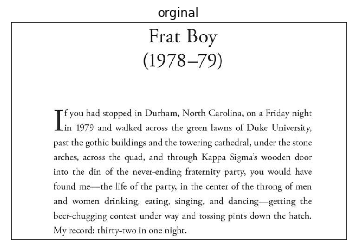

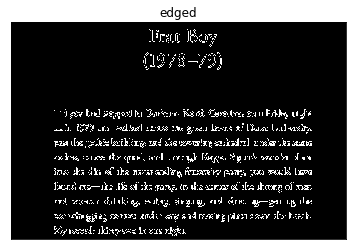

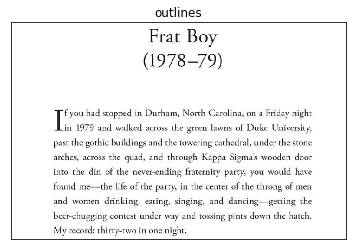

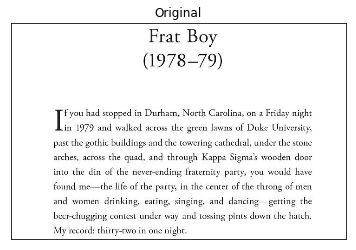

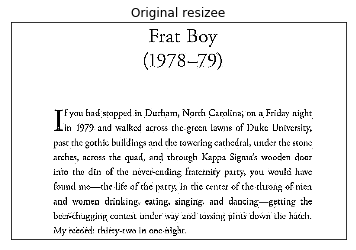

In [52]:
from skimage.filters import threshold_local
import numpy as np
import argparse
import cv2
import imutils
def calc_rectangle(array ):
    if (len(array)== 4):
        y = array[1,0,1]-array[0,0,1]
        x = array[3,0,0]-array[1,0,0]
        rect_area = x*y
    else:
        rect_area = 0 
    
    return rect_area

image= cv2.imread("test3.jpg",1)
ratio = image.shape[0] / 500.0
orig = image.copy()
image = imutils.resize(image, height = 500)
 
# convert the image to grayscale, blur it, and find edges
# in the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(gray, 75, 200)
 
# show the original image and the edge detected image
print ("STEP 1: Edge Detection")
showImage(image,"orginal",gray=False)
showImage(edged,"edged",gray=True)

cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
screenCnt = []
# loop over the contours
for c in cnts:
	# approximate the contour
	
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
 
	# if our approximated contour has four points, then we
	# can assume that we have found our screen
	if len(approx) == 4:
		screenCnt = approx
		break
 
# show the contour (outline) of the piece of paper
print("STEP 2: Find contours of paper")
print(calc_rectangle(screenCnt))
print (len(screenCnt))
if (  len(screenCnt)  != 0  and calc_rectangle(screenCnt) > 500      ):
    cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
    warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)
    #print( screenCnt.shape )
    #print( calc_rectangle(screenCnt) )
    
else:    
    warped=image
    
showImage(image,"outlines")



 
# convert the warped image to grayscale, then threshold it
# to give it that 'black and white' paper effect
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
T = threshold_local(warped, 11, offset = 10, method = "gaussian")
warped = (warped > T).astype("uint8") * 255

# show the original and scanned image
print("STEP 3: Apply perspective transform")

showImage(imutils.resize(orig, height = 650),"Original")
showImage(imutils.resize(warped, height = 650),"Original resizee",True)

